# 3 Drell-Yan Event Generator with VEGAS
Consider the Drell-Yan production process at an electron-positron collider, in which an electron and positron
collide to produce a virtual photon or a Z boson that then decays into a muon-antimuon pair,
$e^+e^- \rightarrow Z/\gamma \rightarrow \mu^+\mu^-$. As described in lecture and in Ref. [5], the differential cross section for center-of-mass energy $E_{CM} = \sqrt{\hat{s}}$ and scattering angle $\theta$ is given by

$$\frac{d\sigma}{d\Omega}(\hat{s}, \cos \theta) = \frac{\alpha^2}{4\hat{s}} \left[ A_0(\hat{s})(1 + \cos^2\theta) + A_1(\hat{s}) \cos \theta \right],$$

Where $A_0$ and $A_1$ are given by

$$
A_0(\hat{s}) = Q_e^2 - 2Q_eV_\mu V_e \chi_1(\hat{s}) + (A_\mu^2 + V_\mu^2)(A_e^2 + V_e^2) \chi_2(\hat{s}),
$$

$$
A_1(\hat{s}) = -4Q_eA_\mu A_e \chi_1(\hat{s}) + 8A_\mu V_\mu A_e V_e \chi_2(\hat{s}),
$$

and the $\chi_1$ and $\chi_2$ are given by

$$
\chi_1(\hat{s}) = \frac{\kappa\hat{s}(\hat{s} - M_Z^2)}{(\hat{s} - M_Z^2)^2 + \Gamma_Z^2 M_Z^2},
$$

$$
\chi_2(\hat{s}) = \frac{\kappa^2 \hat{s}^2}{(\hat{s} - M_Z^2)^2 + \Gamma_Z^2 M_Z^2},
$$

$$
\kappa = \frac{\sqrt{2}G_F M_Z^2}{4\pi\alpha}.
$$

Useful constants are given in the tables below.

| Fermions        | $Q_f$ | $V_f$                                | $A_f$ |
|-----------------|-------|--------------------------------------|-------|
| $u, c, t$       | $+\frac{2}{3}$ | $\left(+\frac{1}{2} - \frac{4}{3}\sin^2\theta_W\right)$ | $+\frac{1}{2}$ |
| $d, s, b$       | $-\frac{1}{3}$ | $\left(-\frac{1}{2} - \frac{2}{3}\sin^2\theta_W\right)$ | $-\frac{1}{2}$ |
| $\nu_e, \nu_\mu, \nu_\tau$ | $0$ | $\frac{1}{2}$ | $+\frac{1}{2}$ |
| $e, \mu, \tau$  | $-1$ | $\left(-\frac{1}{2} + 2\sin^2\theta_W\right)$ | $-\frac{1}{2}$ |


| Variable                | Symbol            | Value                                                   |
|-------------------------|-------------------|---------------------------------------------------------|
| conversion factor       | $GeV−2 ↔ pb$      | $3.894 \times 10^8 \, \text{pb} = 1 \, \text{GeV}^{-2}$ |
| Z boson mass            | $M_Z$             | $91.188 \, \text{GeV}$                                  |
| Z boson width           | $\Gamma_Z$        | $2.4414 \, \text{GeV}$                                  |
| QED running coupling    | $\alpha$          | $\frac{1}{132.507}$                                     |
| Fermi constant          | $G_F$             | $1.16639 \times 10^{-5} \, \text{GeV}^{-2}$             |
| Weinberg angle          | $\sin^2\theta_W$  | $0.222246$                                              |


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp

In [5]:
#Important constants
pb = 3.894e+8 #pb equals GeV^-2
M_z = 91.188 #GeV
Gamma_z = 2.4414 #GeV
alpha = 1/132.507
G_f = 1.16639e-5 #GeV^-2 
sin2_theta = 0.222246 #sin^2(theta_w) 

#Fermions
#Charge of the fermions
Q_u, Q_c, Q_t = 2/3, 2/3, 2/3
Q_d, Q_s, Q_b = -1/3, -1/3, -1/3
Q_mue, Q_mumu, Q_mutau = 0, 0, 0
Q_e, Q_mu, Q_tau = -1, -1, -1

#vector coupling constants
V_u, V_c, V_t = 0.5 - (4/3)*sin2_theta, 0.5 - (4/3)*sin2_theta, 0.5 - (4/3)*sin2_theta
V_d, V_s, V_b = -0.5 - (2/3)*sin2_theta, -0.5 - (2/3)*sin2_theta, -0.5 - (2/3)*sin2_theta
V_mue, V_mumu, V_mutau = 0.5, 0.5, 0.5
V_e, V_mu, V_tau = -0.5 + (2)*sin2_theta, -0.5 + (2)*sin2_theta, -0.5 + (2)*sin2_theta

#axial coupling constants
A_u, A_c, A_t = 0.5, 0.5, 0.5
A_d, A_s, A_b = -0.5, -0.5, -0.5
A_mue, A_mumu, A_mutau = 0.5, 0.5, 0.5
A_e, A_mu, A_tau = -0.5, -0.5, -0.5

#kappa
kappa = (np.sqrt(2)*G_f*M_z**2)/(4*np.pi*alpha)

In [6]:
#We are logging the values of S and E
XMIN, XMAX =  10**2, 200**2
EMIN, EMAX = 10, 200

#cos(theta) so we just do theta here
YMIN, YMAX = -1, 1

In [7]:
#functions to calculate the differential cross section

def s_to_E(s):
    return np.sqrt(s)

def chi_1(s):
    a = kappa * s * (s - M_z**2)
    b = (s - M_z**2)**2 + (M_z*Gamma_z)**2
    return a/b

def chi_2(s):
    a = (kappa * s)**2
    b = (s - M_z**2)**2 + (M_z*Gamma_z)**2
    return a/b

def A0(s):
    a = Q_e**2
    b = 2 * Q_e * V_mu * V_e * chi_1(s)
    c = (A_mu**2 + V_mu**2) * (A_e**2 + V_e**2) * chi_2(s)
    return a - b + c

def A1(s):
    a = 4 * Q_e * A_mu * A_e * chi_1(s)
    b = 8 * A_mu * V_mu * A_e * V_e * chi_2(s)
    return -a + b

#Cos dependent differential cross section
def f_cos(s,cos):
    a = alpha**2/(4 * s)
    b = A0(s) * (1 + cos**2)
    c = A1(s) * cos
    return a * (b + c)

In [2]:
# sampled_values = []
# for _ in range(1_000_000):
#     random_s = np.random.uniform(SMIN, SMAX)
#     random_cos_theta = np.random.uniform(THETAMIN, THETAMAX)
#     value = f(random_s, random_cos_theta)
#     sampled_values.append(value)

# FMAX = max(sampled_values)
# print(FMAX)
FMAX = 6.78765661236851e-07
#FMAX = 262.586

In [3]:
def lego_plot(xAmplitudes, yAmplitudes, nBins, xLabel, yLabel, title):
    x = np.array(xAmplitudes)  # turn x,y data into numpy arrays
    y = np.array(yAmplitudes)  # useful for regular matplotlib arrays

    fig = plt.figure()  # create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection="3d")

    # make histograms - set bins
    hist, xedges, yedges = np.histogram2d(x, y, bins=(nBins, nBins))
    xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])

    xpos = xpos.flatten() / 2.0
    ypos = ypos.flatten() / 2.0
    zpos = np.zeros_like(xpos)

    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    cmap = mpl.colormaps["jet"]
    max_height = np.max(dz)  # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k - min_height) / max_height) for k in dz]

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort="average")
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)   
    plt.show()

In [11]:

def plot_histograms(s_values, angle_values, nBins):
    # Plot histogram for S
    plt.figure(figsize=(10, 4))
    plt.hist(s_values, bins=nBins, color='skyblue', edgecolor='black')
    plt.title('Histogram of S Values')
    plt.xlabel('S')
    plt.ylabel('Frequency')
    plt.show()

    # Plot histogram for E
    plt.figure(figsize=(10, 4))
    plt.hist(s_to_E(s_values), bins=nBins, color='lightcoral', edgecolor='black')
    plt.title('Histogram of E Values')
    plt.xlabel('E')
    plt.ylabel('Frequency')
    plt.show()

    # Plot histogram for theta
    plt.figure(figsize=(10, 4))
    plt.hist(np.arccos(angle_values), bins=nBins, color='lightgreen', edgecolor='black')
    plt.title('Histogram of Theta Values')
    plt.xlabel('Theta')
    plt.ylabel('Frequency')
    plt.show()

    # Plot histogram for cos(theta)
    plt.figure(figsize=(10, 4))
    plt.hist((angle_values), bins=nBins, color='salmon', edgecolor='black')
    plt.title('Histogram of Cos(Theta) Values')
    plt.xlabel('Cos(Theta)')
    plt.ylabel('Frequency')
    plt.show()
    


# Problem A: 

Use standard acceptance-rejection Monte Carlo to generate events (ECM, cos θ) for the DrellYan process in a range ECM ∈ [10, 200] GeV and cos θ ∈ [−1, 1]. Note, usually ECM is fixed in an electronpositron collider, but we will consider a range of energies, which is similar to the situation at a hadron
collider where the partonic center-of-mass energy is not known exactly.

In [13]:
def brute_force(nPoints, seed=None):
    nFunctionEval = 0
    yy1_rej_method = []
    yy2_rej_method = []
    maxWeightEncounteredRej = -1.0e20
    generator = np.random.RandomState(seed=seed)
    
    while len(yy1_rej_method) < nPoints:
        rr = generator.uniform(size=3)
       # yy1, yy2 = XMIN + rr[0] * (XMAX - XMIN), YMIN + rr[1] * (YMAX - YMIN)
        yy1 = np.random.uniform(XMIN, XMAX)
        yy2 = np.random.uniform(YMIN, YMAX)
        nFunctionEval += 1
        f_val = f_cos(yy1, yy2)
        
        if f_val > maxWeightEncounteredRej:
            maxWeightEncounteredRej = f_val
            
        if f_val > FMAX:
            print(
                f" f_val={f_val} exceeds F_VAL_MAX={FMAX}, program will now exit"
            )
            exit(99)

        if f_val / FMAX > rr[2]:
            yy1_rej_method.append(yy1)
            yy2_rej_method.append(yy2)

    return {
        "S": yy1_rej_method,
        "angle": yy2_rej_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncounteredRej,
    }

In [14]:
bf = brute_force(10_000)

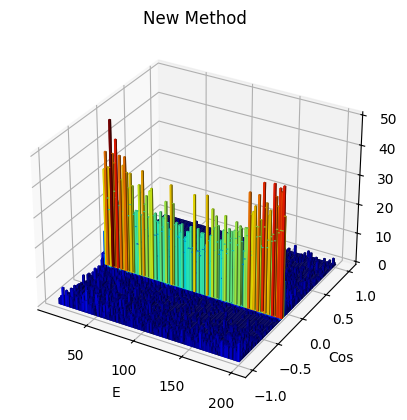

In [16]:
lego_plot(np.sqrt(bf["S"]), (bf["angle"]), 100, "E", "Cos", "New Method")

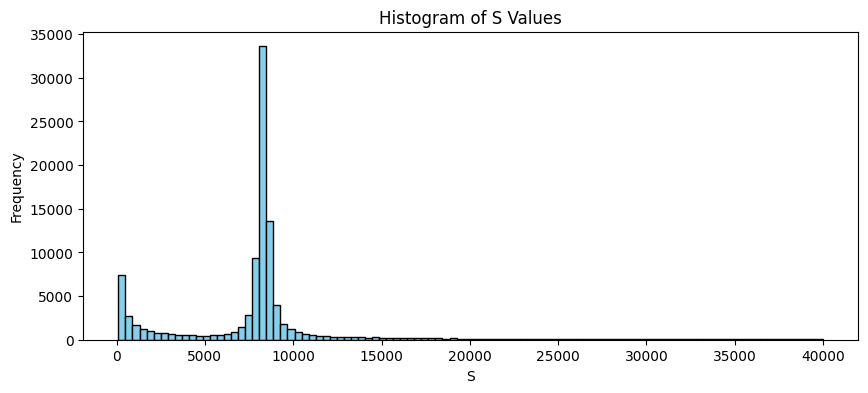

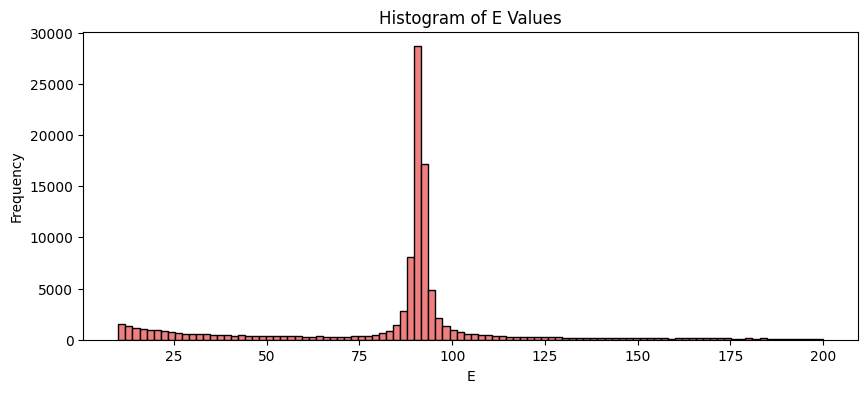

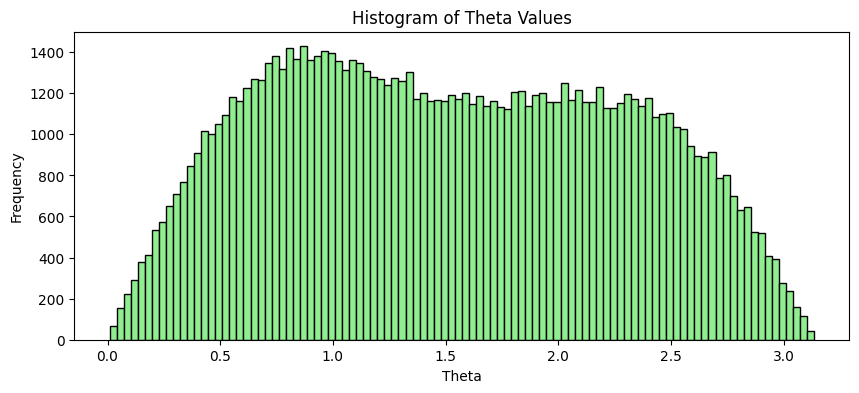

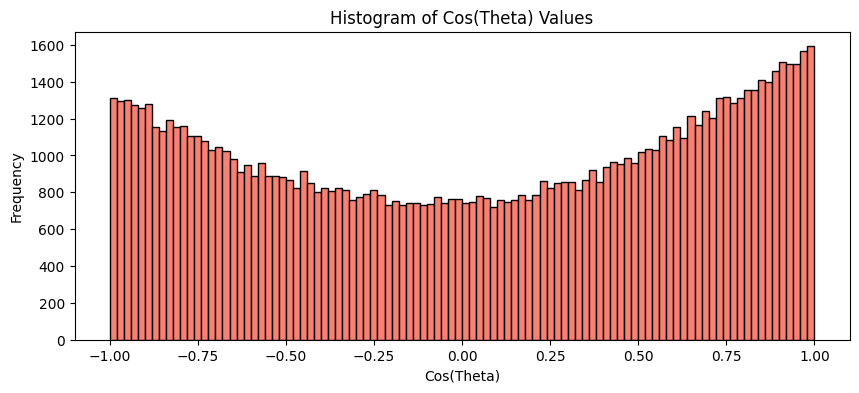

In [16]:
plot_histograms(bf["S"], bf["angle"], 100)

In [20]:
xLow = XMIN + (XMAX - XMIN) / 10 * np.arange(10 + 1) 

xLow

array([  100.,  4090.,  8080., 12070., 16060., 20050., 24040., 28030.,
       32020., 36010., 40000.])

# Problem B : 
Use the VEGAS Monte Carlo method [6, 7] to generate events (ECM, cos θ) for the Drell-Yan
process in a range ECM ∈ [10, 200] GeV and cos θ ∈ [−1, 1]. Compare how many function evaluations are
needed to arrive at the same number of samples, e.g. 10,000. Discuss the settings you use for the VEGAS
algorithm, i.e. how many iterations, what kind of damping factor, and how many bins, etc.

In [14]:
def setup_intervals(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=64):
    """
    Input:
        NN: Number of intervals in [XMIN, XMAX] or [YMIN, YMAX]
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals specified by xLow, yLow: each is a 1D numpy array of size NN+1, with
        xLow[0] = 0, xLow[NN] = ym; yLow[0] = 0, yLow[NN] = ym
    """

    #intitial intervals: uniform intervals between XMIN/YMIN and XMAX/YMAX
    #Called xlow because it is the lower bound of the interval, 
    #as in xLow[i] is the lower bound of the ith interval
    # xLow[0] = 0, xLow[NN] = XMAX, xLow[NN+1] = upper end of XMAX
    xLow = XMIN + (XMAX - XMIN) / NN * np.arange(NN + 1) 
    # length of each interval
    #Will be delx = np.diff(xLow) later on 
    delx = np.ones(NN) * (XMAX - XMIN) / NN 
    # probability density in each interval
    # Will be px = 1.0 / delx / NN later on
    px = np.ones(NN) / (XMAX - XMIN)  # probability density in each interval

    #same as above but for y
    yLow = YMIN + (YMAX - YMIN) / NN * np.arange(NN + 1)    
    dely = np.ones(NN) * (YMAX - YMIN) / NN
    py = np.ones(NN) / (YMAX - YMIN)

    #random number generator. creates a class instance of RandomState
    generator = np.random.RandomState(seed=seed)
    for _ in range(nIterations):

        #In this section we are generating random numbers xx/yy 
        #in the intervals xLow/yLow. First create an array of KK random indeces 
        #between 0 and NN. Then use these indeces to select the lower bound of the interval
        #and add a random number between 0 and the length of the interval to get a random number
        #in the interval. This gets a random number in the interval

        #randit returns an array of KK random integers between 0 and NN
        ixLow = generator.randint(0, NN, size=KK)
        #uniform returns an array of KK random floats between 0 and 1
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform(size=KK)
        iyLow = generator.randint(0, NN, size=KK)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform(size=KK)
        ff = f_cos(xx, yy)

        #This section is the Vegas algorithm. It is a way to adaptively change the intervals
        #to get a better estimate of the integral. The idea is to make the intervals smaller
        #where the function is large and larger where the function is small.

        #The algorithm is based on the idea that the variance of the integral estimate is
        #proportional to the square of the function value. So we want to make the variance
        #of the function value in each interval as close to 1 as possible.
        #f2barx is the sum of the square of the function value in each interval
        #fbarx is the square root of f2barx
        #fbardelxSum is the sum of fbarx times the length of the interval
        #logArgx is the argument of the logarithm in the Vegas algorithm
        #mmx is the number of subintervals to split each interval into
        #xLowNew is the new lower bound of the intervals
        #nCombx is the number of subintervals in each interval
        #We do the same thing for y


        f2barx = np.array(
            [sum((ff[ixLow == i] / py[iyLow[ixLow == i]]) ** 2) for i in range(NN)]
        )
        fbarx = np.sqrt(f2barx)
        f2bary = np.array(
            [sum((ff[iyLow == i] / px[ixLow[iyLow == i]]) ** 2) for i in range(NN)]
        )
        fbary = np.sqrt(f2bary)

        fbardelxSum = np.sum(fbarx * delx)
        fbardelySum = np.sum(fbary * dely)
        logArgx = fbarx * delx / fbardelxSum
        logArgy = fbary * dely / fbardelySum

        mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)
        mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)

        xLowNew = [xLow[i] + np.arange(mmx[i]) * delx[i] / mmx[i] for i in range(NN)]
        xLowNew = np.concatenate(xLowNew, axis=0)
        yLowNew = [yLow[i] + np.arange(mmy[i]) * dely[i] / mmy[i] for i in range(NN)]
        yLowNew = np.concatenate(yLowNew, axis=0)

        nCombx = int(len(xLowNew) / NN)
        nComby = int(len(yLowNew) / NN)

        i = np.arange(NN)

        xLow[:-1] = xLowNew[i * nCombx]
        yLow[:-1] = yLowNew[i * nComby]

        delx = np.diff(xLow)
        dely = np.diff(yLow)
        px = 1.0 / delx / NN
        py = 1.0 / dely / NN

    return xLow, yLow, delx, dely


In [15]:

def vegas(
    nPoints,
    vegasRatioFactor,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    xLow, yLow, delx, dely = setup_intervals(NN, KK, nIterations, alpha_damp, seed)
    vegasRatioMax = vegasRatioFactor * FMAX * NN * NN * np.min(delx) * np.min(dely) # in the original code, delx[NN-2] is the smalles delx (where the maximum occurs)
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20
    errs=0
    RatioList = []

    generator = np.random.RandomState(seed=seed)
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform()
        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = f_cos(xx, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]
        RatioList.append(ratio)
        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
        if ratio > vegasRatioMax:
            errs+=1
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit "
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "ratios": RatioList,
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "S": yy1_vegas_method,
        "cos": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,

    }

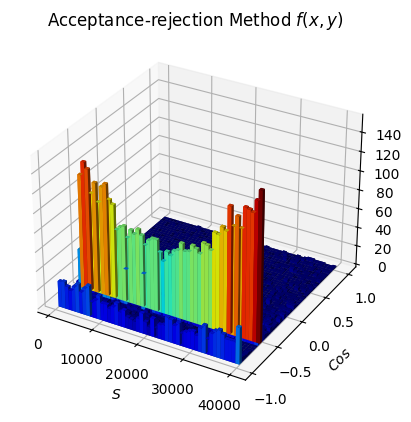

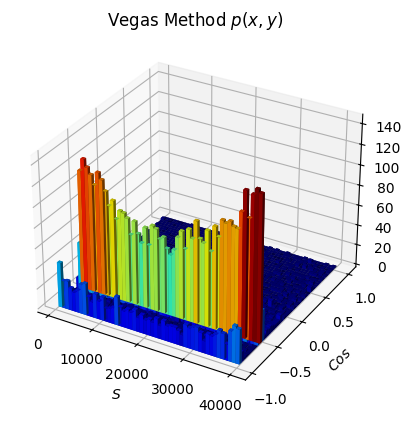

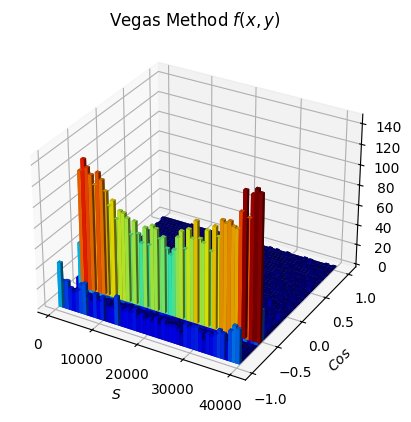

Acceptance-rejection method nPoints=10000, nFunctionEval=667167, maxWeightEncounteredRej=6.779487357876113e-07, F_VAL_MAX=6.78765661236851e-07
Vegas method nPoints=10000, nFunctionEval=54762, maxWeightEncountered=0.0035289090660245433, vegasRatioMax=0.004548751721297666, vegasRatioFactor=6


In [16]:
def plot_results(
    nPoints,
    vegasRatioFactor,
    nBins=50,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=64,
):
    bf = brute_force(nPoints, seed)
    vg = vegas(nPoints, vegasRatioFactor, NN, KK, nIterations, alpha_damp, seed)
    # brute force
    titleRej = r"Acceptance-rejection Method $f(x,y)$"
    lego_plot(bf["S"], bf["angle"], nBins, "$S$", "$Cos$", titleRej)
    plt.show()

    # Vegas method
    titleVrho = r"Vegas Method $p(x,y)$"
    lego_plot(vg["S"], vg["cos"], nBins, "$S$", "$Cos$", titleVrho)
    plt.show()

    titleVegas = r"Vegas Method $f(x,y)$"
    lego_plot(vg["S"], vg["cos"], nBins, "$S$", "$Cos$", titleVegas)
    plt.show()

    print(
         f"Acceptance-rejection method nPoints={nPoints}, nFunctionEval={bf['nFunEval']}, maxWeightEncounteredRej={bf['maxWeightEncountered']}, F_VAL_MAX={FMAX}"
     )
    print(
        f"Vegas method nPoints={nPoints}, nFunctionEval={vg['nFunEval']}, maxWeightEncountered={vg['maxWeightEncountered']}, vegasRatioMax={vg['vegasRatioMax']}, vegasRatioFactor={vegasRatioFactor}"
    )


plot_results(10_000, 6)

In [21]:
vegas_result = vegas(10_000, 6, NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=64)

In [ ]:
def lego_plot(xAmplitudes, yAmplitudes, nBins, xLabel, yLabel, title)

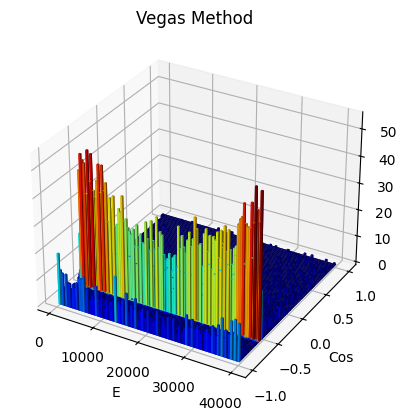

In [22]:
lego_plot(vegas_result["S"], vegas_result["cos"], 100, "E", "Cos", "Vegas Method")

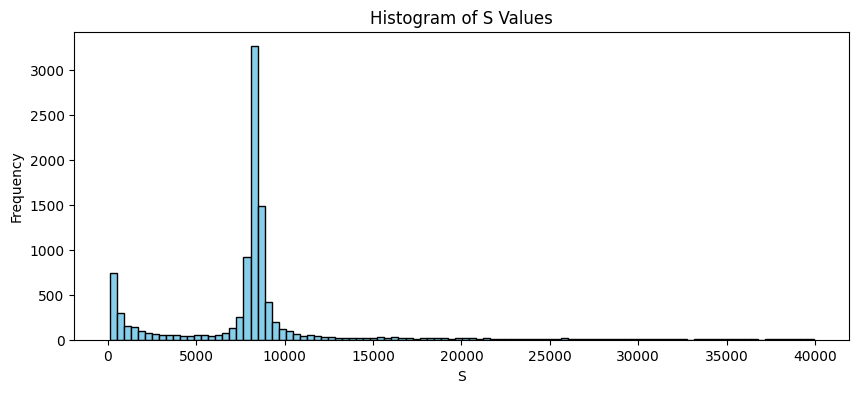

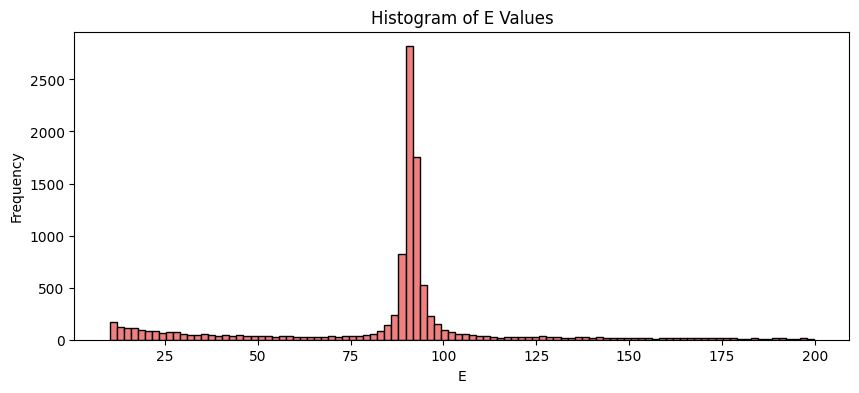

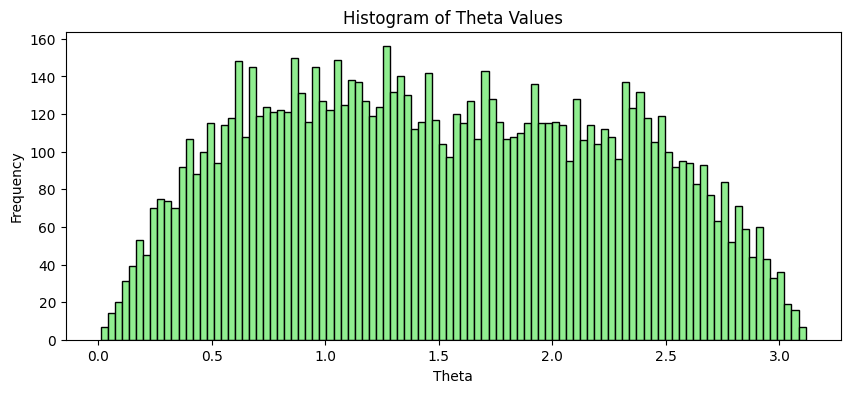

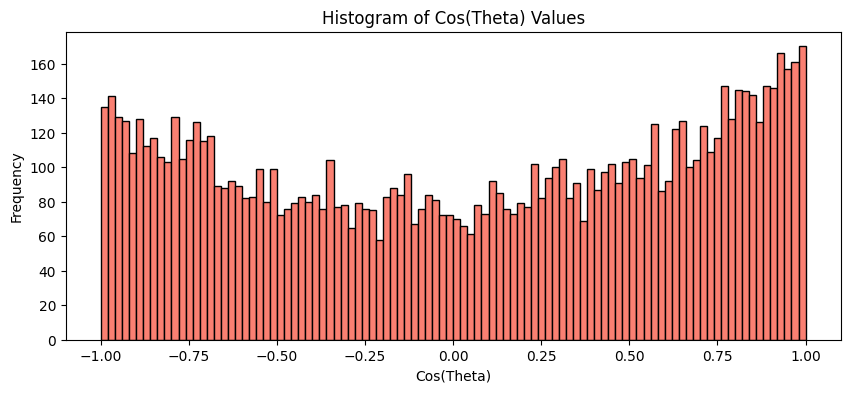

In [23]:
plot_histograms(vegas_result["S"], vegas_result["cos"], 100)

# Part C: error analysis
From class slides:

To obtain a cumulative estimate of the integral and its standard error from each iteration \(j\), we use:

- Cumulative estimate of the integral, \(I\):
$$
I = \frac{\sum_j \frac{\bar{I}_j}{\sigma^2_j}}{\sum_j \frac{1}{\sigma^2_j}}
$$

- Standard error of the integral, \(\sigma_I\):
$$
\sigma_I = \left(\sum_j \frac{1}{\sigma^2_j}\right)^{-\frac{1}{2}}
$$

- Chi-squared, \(\chi^2\), to assess the fit:
$$
\chi^2 = \sum_j \frac{(\bar{I}_j - I)^2}{\sigma^2_j} \approx N_{\text{iter}} - 1
$$

Where:
- $\bar{I}_j$ is the estimate of the integral from iteration j.
- $\sigma^2_j$ is the variance of the integral estimate from iteration j.
- $N_{\text{iter}}$ is the number of iterations.
